# Inverse design optimization of a metalens

In this notebook, we will use inverse design and the Tidy3D `adjoint` plugin to design a high numerical aperture (NA) metalens for optimal focusing to a point. This demo also introduces how to use the `adjoint` plugin for objective functions that depend on the `FieldMonitor` outputs.

We will follow the basic set up from Mansouree et al. "Large-Scale Parametrized Metasurface Design Using Adjoint Optimization". The published paper can be found [here](https://pubs.acs.org/doi/abs/10.1021/acsphotonics.0c01058) and the arxiv preprint can be found [here](https://arxiv.org/abs/2101.06292).


<!-- View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=d226dea4-9a65-4481-83d0-7f7d4cbfd388). -->

## Setup

We first perform basic imports of the packages needed.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run as run_adj
import jax
import jax.numpy as jnp

The metalens design consists of a rectangular array of Si rectangular prisms sitting on an SiO2 substrate.

Here we define all of the basic parameters of the setup, including the wavelength, NA, geometrical dimensions, and material properties.


In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 850 * nm

# desired numerical aperture
NA = 0.94

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
H = 430 * nm
S = 320 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate between source and Si unit cells
thickness_sub = 100 * nm

# side length of entire metalens (um)
side_length = 6

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / S)

print(f"for diameter of {side_length:.1f} um, have {N} cells per side")
print(f"full metalens has area of {side_length**2:.1f} um^2 and {N*N} total cells")

# Define material properties at 600 nm
n_Si = 3.84
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
Si = td.Medium(permittivity=n_Si**2)

# define symmetry
symmetry = (-1, 1, 0)

for diameter of 6.0 um, have 18 cells per side
full metalens has area of 36.0 um^2 and 324 total cells


Next, we will compute some important quantities derived from these parameters.

In [3]:
# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S

# focal length given diameter and numerical aperture
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# total domain size in z: (space -> substrate -> unit cell -> 1.7 focal lengths)
length_z = space_below_sub + thickness_sub + H + 1.7 * focal_length

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)


## Create Metalens Geometry

Now we will define the structures in our simulation. We will first generate the substrate as a regular `td.Box`.

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -1000),
        rmax=(+td.inf, +td.inf, -length_z / 2 + space_below_sub + thickness_sub)
    ),
    medium=SiO2,
)

Next, we will write a function to make a list of `JaxStructure` objects corresponding to each unit cell.

> Note that the adjoint plugin does not yet support `GeometryGroup` for `JaxBox`, so we will keep them as individual `JaxStructure` objects for now.

In [5]:
# define coordinates of each unit cell
centers_x = S * np.arange(N) - length_xy / 2.0 + S / 2.0
centers_y = S * np.arange(N) - length_xy / 2.0 + S / 2.0
center_z = -length_z / 2 + space_below_sub + thickness_sub + H / 2.0

focal_z = center_z + H / 2 + focal_length


x_centers, y_centers = np.meshgrid(centers_x, centers_y, indexing="ij")
xs = x_centers.flatten()
ys = y_centers.flatten()

def get_sizes(params):
    """Returns the actual side lengths of the boxes as a function of design parameters from (-inf, +inf)."""
    return S * (jnp.tanh(params) + 1.0) / 2.0

# initially, start with parameters of 0 (all boxes have side length S/2)
params0 = 0 * np.ones(x_centers.shape)

def make_structures(params, apply_symmetry: bool = True):
    """Make the JaxStructure objects that will be used as .input_structures."""
    
    sizes = get_sizes(params)
    nx, ny = sizes.shape
    geometries = []
    
    for i in range(nx):
        i_quad = max(i, nx - 1 - i)
        for j in range(ny):
            j_quad = max(j, ny - 1 - j)
            size = sizes[i_quad, j_quad]
            x0 = x_centers[i, j]
            y0 = y_centers[i, j]

            if apply_symmetry and symmetry[0] != 0 and x0 < -S/2:
                continue

            if apply_symmetry and symmetry[1] != 0 and y0 < -S/2:
                continue        

            geometry = tda.JaxBox(
                center=(x0, y0, center_z),
                size=(size, size, H)
            )
        
            geometries.append(geometry)
    medium = tda.JaxMedium(permittivity=n_Si**2)
    return [tda.JaxStructure(medium=medium, geometry=geo) for geo in geometries]

structures = make_structures(params0)

## Define grid specification

We define the grid based on the properties of the geometry. The metalens is quasi-periodic in x and y, in that we have clearly defined unit cells, but each is slightly modified from its neighbors. Such structures are best resolved with a grid that matches the periodicity, which is why we use a uniform grid in x and y. In z, we use the automatic nonuniform grid that will place a higher grid density around the metalens region, and a lower one in the air region away from the metalens. To speed up the auto meshing in the region with the pillars, we put an override box in the grid specification.

In [6]:
# steps per unit cell along x and y
grids_per_unit_length = 10

# uniform mesh in x and y
grid_x = td.UniformGrid(dl=S / grids_per_unit_length)
grid_y = td.UniformGrid(dl=S / grids_per_unit_length)

# in z, use an automatic nonuniform mesh with the wavelength being the "unit length"
grid_z = td.AutoGrid(min_steps_per_wvl=grids_per_unit_length)

# we need to supply the wavelength because of the automatic mesh in z
grid_spec = td.GridSpec(
    wavelength=wavelength, grid_x=grid_x, grid_y=grid_y, grid_z=grid_z
)

# put an override box over the pillars to avoid parsing a large amount of structures in the mesher
grid_spec = grid_spec.copy(
    update=dict(
        override_structures=[
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(-td.inf, -td.inf, -length_z / 2 + space_below_sub),
                    rmax=(td.inf, td.inf, center_z + H / 2),
                ),
                medium=Si,
            )
        ]
    )
)


## Define Source

Now we define the incident fields.  We simply use an x-polarized, normally incident plane wave with Gaussian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](../_autosummary/tidy3d.PlaneWave.html#tidy3d-planewave) and the [gaussian source documentation](../_autosummary/tidy3d.GaussianPulse.html#tidy3d-gaussianpulse)

In [7]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0, 0, -length_z / 2 + space_below_sub / 10.0),
    direction="+",
    pol_angle=0,
)

run_time = 50 / fwidth


## Define Monitors

Now we define the monitor that measures field output from the FDTD simulation.  For simplicity, we use measure the fields at the central frequency at the focal spot.

This will be the monitor that we use in our objective function, so it will go into `JaxSimulation.output_monitors`.

In [8]:
# To decrease the amount of data stored, only store the E fields
fields = ["Ex", "Ey", "Ez"]

monitor_focal = td.FieldMonitor(
    center=[0.0, 0.0, focal_z],
    size=[0, 0, 0],
    freqs=[f0],
    name="focal_point",
    fields=fields,
)

## Create Simulation

Now we can put everything together and define a [JaxSimulation](../_autosummary/tidy3d.plugins.adjoint.JaxSimulation.html) object to be run.



We get a number of warnings about structures being too close to the PML. In FDTD simulations, this can result in instability, as PML are absorbing for propagating fields, but can be amplifying for evanescent fields. This particular simulation runs without any issues even with PML on the sides, but it is best to heed these warnings to avoid problems. There are two ways that we can fix the simulation: one is to just put some space between the last of the metalens boxes and the PML. The other is to use adiabatic absorbers on the sides, which are always stable. The only downside of the absorbers is that they are slightly thicker than the PML, making the overall simulation size slightly larger. This is why we only put them along x and y, while we leave the PML in z.

> Note: we add symmetry of (-1, 1, 0) to speed up the simulation by approximately 4x taking into account the symmetry in our source and dielectric function.

In [9]:
def make_sim(angles, apply_symmetry: bool=True):
    metalens = make_structures(angles, apply_symmetry=apply_symmetry)
    sim = tda.JaxSimulation(
        size=sim_size,
        grid_spec=grid_spec,
        structures=[substrate],
        input_structures=metalens,
        sources=[source],
        monitors=[],
        output_monitors=[monitor_focal],
        run_time=run_time,
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.absorber(), y=td.Boundary.absorber(), z=td.Boundary.pml()
        ),
        symmetry=symmetry,
    )
    return sim

sim = make_sim(params0)

[17:18:16] WARNING: Override structures take no effect along x-axis. If      ]8;id=481493;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=523636;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=949063;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=590111;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

The warnings are just letting us know that we are using uniform grid along x and y (per our spec) even though the override structures have some extent in these dimensions. We can ignore as this is intended.

## Visualize Geometry

Lets take a look and make sure everything is defined properly.


           WARNING: Override structures take no effect along x-axis. If      ]8;id=573467;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=653368;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=141245;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=155886;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along x-axis. If      ]8;id=824434;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=745876;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=644458;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=744222;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along x-axis. If      ]8;id=947253;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=185928;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=703513;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=100705;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

[17:18:17] WARNING: Override structures take no effect along x-axis. If      ]8;id=986519;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=656170;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=213399;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=74067;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along x-axis. If      ]8;id=338752;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=149320;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=362736;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=923315;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along x-axis. If      ]8;id=892422;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=459658;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

           WARNING: Override structures take no effect along y-axis. If      ]8;id=302433;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=898838;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#556\556]8;;\
           intending to apply override structures to this axis, use                          
           'AutoGrid'.                                                                       

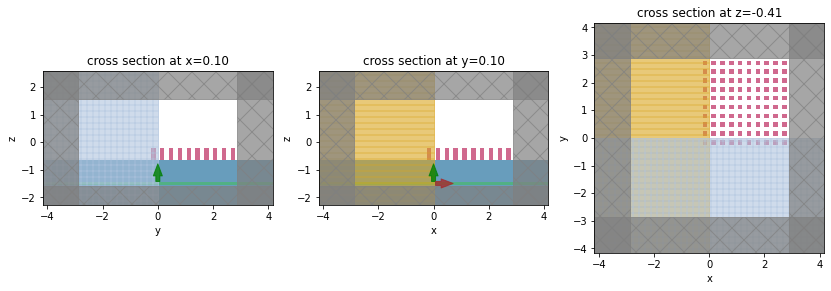

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

sim.plot(x=0.1, ax=ax1)
sim.plot(y=0.1, ax=ax2)
sim.plot(z=-length_z / 2 + space_below_sub + thickness_sub + H / 2, ax=ax3)
plt.show()


## Objective Function

Now that our simulation is set up, we can define our objective function over the `JaxSimulationData` results.

We first write a function to take a `JaxSimulationData` object and return the intensity at the focal point.

Next, we write a function to 

1. Set up our simulation given our design parameters.

2. Run the simulation through the adjoint `run` function.

3. Compute and return the intensity at the focal point.


In [11]:
# turn off warnings as we understand they are just about AutoGrid and can be ignored in our case
td.config.logging_level = "ERROR"

def measure_focal_intensity(sim_data: tda.JaxSimulationData) -> float:
    """Measures electric intensity at focal point."""
    return jnp.sum(sim_data.get_intensity('focal_point').values)

def J(params) -> float:
    """Objective function, returns intensity at focal point as a function of params."""
    sim = make_sim(params)
    sim_data = run_adj(sim, task_name='metalens_adj', verbose=False)
    return measure_focal_intensity(sim_data)
    

We first run our function to test that it works and see the starting value.

In [12]:
J(params0)

DeviceArray(11.112829, dtype=float32)

Next, we use `jax` to get a function returning the objective value and its gradient, given some parameters.

In [13]:
dJ = jax.value_and_grad(J)

And try it out.

In [14]:
val, grad = dJ(params0)

In [15]:
print(val)
print(grad)

11.112829
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0. 

### Normalize Objective

To normalize our objective function value to something more understandable, we first run a simulation with no boxes to compute the focal point intensity in this case. Then, we construct a new objective function value that normalizes the raw intensity by this value, giving us an "intensity enhancement" factor. In this normalization, if our objective is given by "x", it means that the intensity at the focal point is "x" times stronger with our design than with no structures at all.

In [16]:
params_empty = -1e5 * np.ones_like(params0)
J_empty = np.array(J(params_empty))

def J_normalized(params):
    return J(params) / J_empty

val_normalized = val / J_empty

dJ_normalized = jax.value_and_grad(J_normalized)

print(val_normalized)

0.8701368


## Optimization

With our objective function set up, we can now run the optimization.

As before, we will use a hand-written Adam optimizer, passing in our initial parameters of all zeros (corresponding to boxes of side length `S/2`).

In [17]:
J_history = [val_normalized]
params_history = [params0]

def optimize(
    params,
    step_size=0.02,
    num_steps=18,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):

    mt = np.zeros_like(params)
    vt = np.zeros_like(params)

    for i in range(num_steps):

        t = i + 1
        print(f"step = {t}")

        intensity, gradient = dJ_normalized(params)
        gradient = np.array(gradient).copy()

        mt = beta1 * mt + (1 - beta1) * gradient
        vt = beta2 * vt + (1 - beta2) * gradient**2

        mt_hat = mt / (1 - beta1**t)
        vt_hat = vt / (1 - beta2**t)

        update = step_size * (mt_hat / (np.sqrt(vt_hat) + epsilon))

        J_history.append(intensity)
        print(f"\tJ = {intensity:.4e}")
        print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

        params += update
        params_history.append(params.copy())
    return params


In [18]:
params_after = optimize(params0)

step = 1
	J = 8.7014e-01
	grad_norm = 7.6420e-01
step = 2
	J = 1.9787e+00
	grad_norm = 1.0889e+00
step = 3
	J = 4.7556e+00
	grad_norm = 1.5125e+00
step = 4
	J = 7.5183e+00
	grad_norm = 1.8003e+00
step = 5
	J = 1.3061e+01
	grad_norm = 2.8312e+00
step = 6
	J = 2.0482e+01
	grad_norm = 3.2139e+00
step = 7
	J = 2.7078e+01
	grad_norm = 2.9390e+00
step = 8
	J = 3.1875e+01
	grad_norm = 2.3666e+00
step = 9
	J = 3.2899e+01
	grad_norm = 3.0182e+00
step = 10
	J = 3.6514e+01
	grad_norm = 2.5290e+00
step = 11
	J = 4.0030e+01
	grad_norm = 2.7143e+00
step = 12
	J = 4.2698e+01
	grad_norm = 2.6679e+00
step = 13
	J = 4.3889e+01
	grad_norm = 2.8564e+00
step = 14
	J = 4.5887e+01
	grad_norm = 2.5886e+00
step = 15
	J = 4.7922e+01
	grad_norm = 2.1898e+00
step = 16
	J = 4.9084e+01
	grad_norm = 2.0404e+00
step = 17
	J = 4.9050e+01
	grad_norm = 2.3652e+00
step = 18
	J = 4.9275e+01
	grad_norm = 2.8614e+00


In [19]:
params_after = params_history[-1]

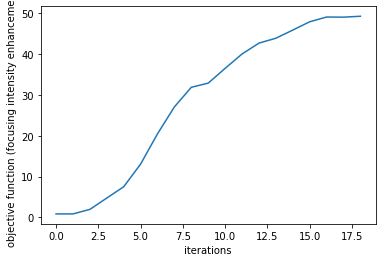

In [20]:
plt.plot(J_history)
plt.xlabel('iterations')
plt.ylabel('objective function (focusing intensity enhancement)')
plt.show()

In [21]:
sim_before = make_sim(0 * params_after, apply_symmetry=False).to_simulation()[0]
sim_after = make_sim(params_after, apply_symmetry=False).to_simulation()[0]


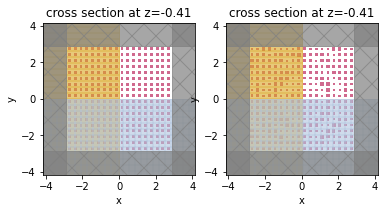

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2)

sim_before.plot(z=center_z, ax=ax1)
sim_after.plot(z=center_z, ax=ax2)

plt.show()

In [23]:
sim_after_mnt = sim_after.updated_copy(monitors=list(sim_after.monitors) + 
[
    td.FieldMonitor(
        size=(0, td.inf, td.inf),
        center=(0,0,0),
        freqs=[f0],
        name='fields_yz',
    ),
    td.FieldMonitor(
        size=(td.inf, td.inf, 0),
        center=(0,0,focal_z),
        freqs=[f0],
        name='far_field',
    ),    
])

In [24]:
sim_data_after_mnt = web.run(sim_after_mnt, task_name='meta_near_field_after')

[17:51:51] Created task 'meta_near_field_after' with task_id                    ]8;id=667094;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=849061;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#186\186]8;;\
           'fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1'.                                    

           View task using web UI at ]8;id=979625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\'https://tidy3d.simulation.cloud/workbench]8;;\ ]8;id=565474;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=777533;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=979625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\?]8;;\]8;id=247161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\taskId]8;;\]8;id=979625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\=]8;;\]8;id=247161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\fdve]8;;\]8;id=979625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-209652b2-2a2c-4eb7-b394-003a7f3266f3v1\-209652b2-2a2c-4eb7-b394-003a7f3266f3v1']8;;\.                             

Output()

[17:51:53] status = queued                                                      ]8;id=648317;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=997623;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#360\360]8;;\

Output()

[17:51:55] status = preprocess                                                  ]8;id=177210;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=769971;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#354\354]8;;\

[17:52:03] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get  ]8;id=976729;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=841795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#340\340]8;;\
           the billed FlexCredit cost after a simulation run.                                

           starting up solver                                                   ]8;id=333111;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=802979;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#376\376]8;;\

           running solver                                                       ]8;id=272287;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=846761;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#386\386]8;;\

Output()

[17:52:13] status = postprocess                                                 ]8;id=367750;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=297496;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#417\417]8;;\

Output()

[17:52:20] status = success                                                     ]8;id=664853;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=991257;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#424\424]8;;\

Output()

[17:52:21] loading SimulationData from simulation_data.hdf5                     ]8;id=543088;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=986536;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#602\602]8;;\

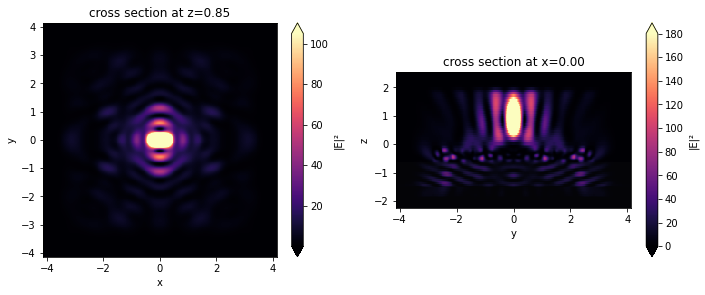

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data_after_mnt.plot_field('far_field', 'int', vmax=105, ax=ax1)
sim_data_after_mnt.plot_field('fields_yz', 'int', vmax=180, ax=ax2)
plt.show()

## Conclusions

We notice that our metalens does quite well at focusing at this high NA! For the purposes of demonstration, this is quite a small device, but the same the same principle can be applied to optimize a much larger metalens.